In [42]:
import numpy as np
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow import keras


**Задача:** создать модель машинного обучения для классификации питомцев : кошек и собак (dataset = cats_and_dogs_filtered.zip ).
Выбираем предварительно обученную модель для использования. Рассмотрим архитектуру Xception, обученную на наборе данных ImageNet.


In [43]:
# Распаковка набора данных и указание пути к обучающему и проверочному набору.
with zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
base_dir = '/content/cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [44]:
# Загружаем изображения

training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))
val_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(150, 150))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Data pre-processing

In [45]:

data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

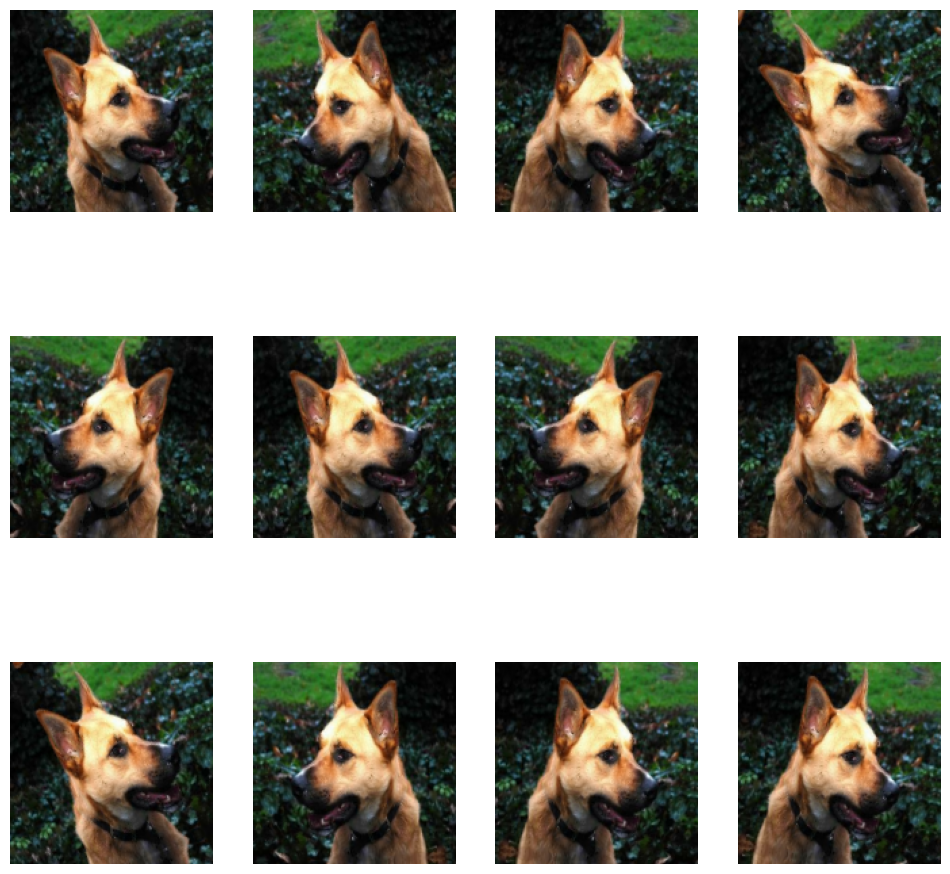

In [46]:
# Результат прменения преобразования к одному и тому же изображению. 
for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

### Feature Extraction

In [47]:
# Создание базовой модели на основе предварительно обученной модели Xception
# Загружаем в модель веса, обученные на ImageNet
# Финальный слой не используем
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)  

In [48]:
# Заморозка слоев базовой модели, чтобы они не обновлялись в процессе обучения. 
base_model.trainable = False

In [49]:
# Создание выходного слоя базовой модели
inputs = keras.Input(shape=(150, 150, 3))

# Наращивание данных
x = data_augmentation(inputs) 

# Преобразование данных в диапазон (-1,1)
x = tf.keras.applications.xception.preprocess_input(x)

In [50]:
# Базовая модель работает в режиме вывода
x = base_model(x, training=False)

# Преобразование пр изнаков из базовой модели в векторы
x = keras.layers.GlobalAveragePooling2D()(x)

# Применение регуляризации Drpout
x = keras.layers.Dropout(0.2)(x)

# Добавление финального слоя
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [53]:
# Тренировка модели
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras.metrics.BinaryAccuracy())
model.fit(training_set, epochs=15, validation_data=val_dataset)


Epoch 1/15


63/63 [==============================] - 131s 2s/step - loss: 0.0790 - binary_accuracy: 0.9675 - val_loss: 0.0671 - val_binary_accuracy: 0.9730
Epoch 2/15
63/63 [==============================] - 118s 2s/step - loss: 0.0818 - binary_accuracy: 0.9690 - val_loss: 0.0676 - val_binary_accuracy: 0.9720
Epoch 3/15
63/63 [==============================] - 117s 2s/step - loss: 0.0747 - binary_accuracy: 0.9720 - val_loss: 0.0698 - val_binary_accuracy: 0.9720
Epoch 4/15
63/63 [==============================] - 111s 2s/step - loss: 0.0698 - binary_accuracy: 0.9705 - val_loss: 0.0859 - val_binary_accuracy: 0.9630
Epoch 5/15
63/63 [==============================] - 123s 2s/step - loss: 0.0656 - binary_accuracy: 0.9715 - val_loss: 0.0702 - val_binary_accuracy: 0.9720
Epoch 6/15
63/63 [==============================] - 118s 2s/step - loss: 0.0692 - binary_accuracy: 0.9755 - val_loss: 0.0705 - val_binary_accuracy: 0.9690
Epoch 7/15
63/63 [==============================] - 120s 2s/step - loss: 0.0625 -

### Fine-tuning the model

In [24]:
# Размораживание базовой модели
base_model.trainable = True

In [25]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=keras.metrics.BinaryAccuracy())

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
#rm -rf logs
%load_ext tensorboard
log_folder = 'logs'

callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:
model.fit(training_set, epochs=15,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/15
63/63 [==============================] - 399s 6s/step - loss: 0.0728 - binary_accuracy: 0.9725 - val_loss: 0.0597 - val_binary_accuracy: 0.9730
Epoch 2/15
63/63 [==============================] - 392s 6s/step - loss: 0.0395 - binary_accuracy: 0.9820 - val_loss: 0.0561 - val_binary_accuracy: 0.9760
Epoch 3/15
63/63 [==============================] - 379s 6s/step - loss: 0.0412 - binary_accuracy: 0.9855 - val_loss: 0.0561 - val_binary_accuracy: 0.9770
Epoch 4/15
63/63 [==============================] - 395s 6s/step - loss: 0.0313 - binary_accuracy: 0.9880 - val_loss: 0.0522 - val_binary_accuracy: 0.9810
Epoch 5/15
63/63 [==============================] - 397s 6s/step - loss: 0.0333 - binary_accuracy: 0.9890 - val_loss: 0.0474 - val_binary_accuracy: 0.9790
Epoch 6/15
63/63 [==============================] - 394s 6s/step - loss: 0.0201 - binary_accuracy: 0.9935 - val_loss: 0.0515 - val_binary_accuracy: 0.9810
Epoch 7/15
63/63 [==============================] - 391s 6s/step - los

In [67]:
img_path = 'dog.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 175ms/step
Predicted: [('n02090379', 'redbone', 0.9931144), ('n02087394', 'Rhodesian_ridgeback', 0.0063085207), ('n02100583', 'vizsla', 0.00044065755)]
